In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.ThesisCraft import craft

if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']
plt.rcParams.update({'font.size':16})

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
import random
random.seed(0)
#scene.addRandomGroundUsersUniformCircular(5, r = 5000)
for x in range(-2000, 2001, 500):
    for y in range(-2000, 2001, 500):
        if random.random() < 0.25:
          scene.addUser(vector((x, y, 0)))

judge = Judge(scene, craft)

%load_ext snakeviz
scene.render(size=50000)

def MakePlotUpdater(iters):
  fig, ax = plt.subplots(2, figsize=(8,10))
  ax[0].set_ylim(-50, 50)
  ax[1].set_xlim(0, iters)
  highest = 0
  lowest = 999
  
  curves = []
  
  def update(i, scores, best):
    # Fade out old curves
    for curve in curves:
      curve.set_alpha(curve.get_alpha() * 0.9)
    
    curves.append(ax[0].plot(scores, alpha=1)[0])
    nonlocal highest, lowest
    highest = max(highest, scores.max())
    if scores.max() > 0:
      lowest = min(lowest, scores.max())
    ax[0].set_ylim(lowest-1, highest+1)
    ax[1].set_ylim(lowest-1, highest+1)
    fig.canvas.draw()
    
    ax[1].scatter([i], [scores.mean()], s=1, color='green')
    
    ax[1].scatter([i], [scores.max()], s=1)
    ax[1].scatter([i], [best], color='red', s=1)
  return update

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [3]:
from tqdm.auto import tqdm

if 'thesis.optimize.functions' in sys.modules: del sys.modules['thesis.optimize.functions']
from thesis.optimize.functions import (
  SplineyFitnessHelper, batteryReward, throughputReward, throughputPenalty,
  energyPenalty, gravityReward, radiusPenalty, altitudePenalty, energyPenalty,
  speedPenalty, thrustPenalty
)
times = pd.date_range(start = '2020-11-28T06', end = '2020-11-29T06', freq='10S', tz='America/Detroit').to_series()

if 'thesis.optimize.BaseOptimizer' in sys.modules: del sys.modules['thesis.optimize.BaseOptimizer']
if 'thesis.optimize.PSOv2' in sys.modules: del sys.modules['thesis.optimize.PSOv2']
from thesis.optimize.PSOv2 import PSO

if 'thesis.optimize.ParallelNelderMead' in sys.modules: del sys.modules['thesis.optimize.ParallelNelderMead']
from thesis.optimize.ParallelNelderMead import ParallelNelderMead
from thesis.optimize.PSOv2 import PSO


initial_waypoint = [0.4, 1800.1, 1000, 0, 5, 5]


from thesis.Flight import Flight
from math import pi

bat_cap = 15.5 * 650
charge_start = 0.5*bat_cap
charge_start_ratio = charge_start / bat_cap



numPoints = 4 * 24
numWaypoints = numPoints * 4
numCodons = 6 + numWaypoints * 5

m = 1800 / math.sqrt(2)

# Where we start
template = [3000, 0.1, 0.5, 0.5, 0.5, 0.5] + [
    0.4, 1800.1, 0, 5, 5,
    1800.3, 0.2, 3*pi/2, 5, 5,
    0.2, -1800.3, pi, 5, 5,
    -1800.1, 0.4, pi / 2, 5, 5,
] * numPoints
# How much to offset our initial guesses
# Larger numbers maybe implies more impulse
offsets = [200, 0.1, 0.1, 0.1, 0.1, 0.1] + [50, 50, 0.05, 0.5, 0.5] * 4 * numPoints

# Fix up SageMath numbers
template = list(map(float, template))
offsets = list(map(float, offsets))

#template[0:6] = initial_waypoint

bounds = [(0, 9000)] + [
  (0.01, 1)
] * 5 + [
  # XYZ
  (-2000, 2000),
  (-2000, 2000),
  #(1000, 10000),
  # heading
  (None, None), # TODO make a proper distance formula for direction
  # Alphas
  (0, 12),
  (0, 12),
] * 4 * numPoints

len(template), len(offsets), len(bounds)

(1926, 1926, 1926)

In [4]:
mode = 'pso'
its=1000
numParticles = 128


def createParticle(i):
    if i == 0:
      return template

    # This is kinda silly
    #np.random.seed(random.randint(0,99999999))
    at = template.copy()
    for i in range(len(template)):
      off = offsets[i % len(offsets)]
      at[i] += np.random.uniform(-off * 2, off * 2)
    return at

def createVertex(i):
  if i == numCodons:
    return template
  else:
    at = template.copy()
    at[i] += offsets[i % len(offsets)] * 5
    return at

helper = SplineyFitnessHelper(
  judge, craft, times,
  expr = [
    #batteryReward(),
    #gravityReward() * 0.5L,
    radiusPenalty(2000) * 1e-6L,
    altitudePenalty(1000, 10000),
    throughputReward() / 1e6L / len(scene.users),
    # Here is where we would put our budget
    # For testing, let's request a 500 Wh margin
    energyPenalty(-1000, gravityCoeff = 1.0),
    thrustPenalty(hi = 100),
    speedPenalty(lo = 6, hi = 25)
  ],
  desiredDuration = 24*3600,
  zMode = 'schedule'
)

baselineVec = createVertex(1)
print('  baseline fitness is %.2f=%s' % (
  helper.getFitness(initial_charge = charge_start_ratio, debug=False)(baselineVec),
  helper.getFitness(initial_charge = charge_start_ratio, debug=True)(baselineVec)
))


fitness = helper.getFitness(initial_charge = charge_start_ratio)


  baseline fitness is -440000.34=((((((RP<-0.0>*1e-06)+AP<-0.0>)+((TR<301121108.7161326>/1000000.0)/11))+EP<-440027.7180846608>)+TRP<-0.0>)+VP<-0.0>)


starting
Generated initial 128 particles


<IPython.core.display.Javascript object>


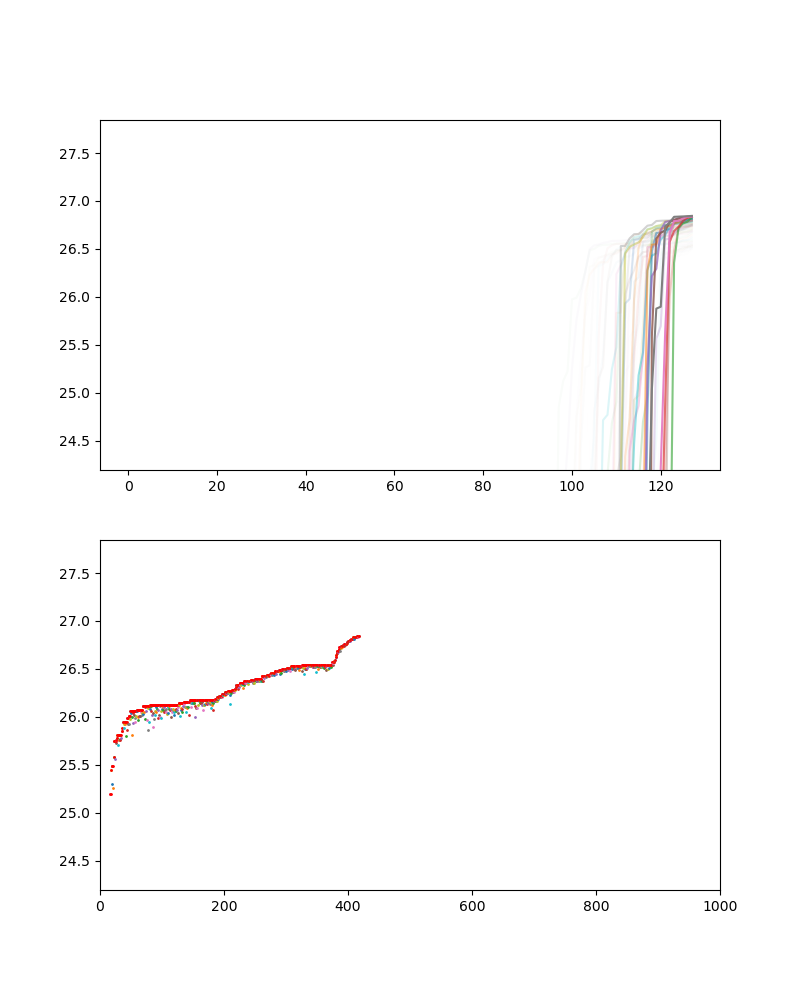

KeyboardInterrupt: 

In [5]:
if mode == 'pso':
  def wRamp(it):
    # 0.99 gave reasonable results, but had a lot of fast particles still...
    from math import sqrt
    return 0.97 / (1 + sqrt(it) / 500)

  optimizer = PSO(numParticles, numCodons, createParticle, fitness, processes=30, wSchedule = wRamp, bounds=bounds)
elif mode == 'nm':
  optimizer = ParallelNelderMead(numCodons, createParticle, fitness, processes=30, k=128, adaptive = True)

data = []

%matplotlib notebook
upd = MakePlotUpdater(its)
prog = tqdm(range(its)) 

def onIteration(i):
    
  
    if mode == 'pso':
      pt = [(vw[2], vw[1].length()) for vw in optimizer.particles]
      best = optimizer.best[1]
    elif mode == 'nm':
      pt = [(vw.fitness, 0) for vw in optimizer.vertices]
      best = pt[-1][0]
    data.append(pt)
    scores = np.array([v[0] for v in pt])
    
    desc = str(round(best, 2))

    if mode == 'pso':
      vels = np.array([vw[1].length() for vw in optimizer.particles])
      desc += ' v~%.2f' % vels.mean()
      
    # Count our evaluations
    desc += ' f(...)*%d' % fitness.evaluations.value

#       print('iter=%d\tlow score=%.2f\thigh score=%.2f/%.2f\tvel~%.2f-%.2f' % (
#         i,
#         scores.min(),
#         scores.max(),
#         swarm.best[1],
#         vels.min(),
#         vels.max()
#       ))

    

    upd(i, scores, best)
    prog.set_description(desc)


optimizer.iterateMany(iterations = prog, cb=onIteration)
# vecToTrajectory = helper.getTrajBuilder()
# vec=createParticle(0)
# vecToTrajectory(vec)[0].render().show()
# helper.getFitness(vecToTrajectory, debug=True)(vec)

# Gather some data for the next run

if mode == 'pso':
  bestVec = optimizer.best[0]
  bestFit = optimizer.best[1]
elif mode == 'nm':
  bestVec = optimizer.vertices[-1].vec
  bestFit = optimizer.vertices[-1].fitness

traj, alphas = helper.getTrajBuilder()(bestVec)
flight = Flight(craft, traj, alphas)
stats = judge.flightStats(flight, initial_charge=charge_start_ratio, times=times)
next_start = bestVec[-6:]
# TODO make proper
next_start[0] *= traj.scale
next_start[1] *= traj.scale
print('  final fitness is %.2f=%s' % (bestFit, helper.getFitness(initial_charge = charge_start_ratio, debug=True)(bestVec)))
# best vector, best score, ending waypoint, ending charge, stats
# (
#   bestVec,
#   flight,
#   bestFit,
#   next_start,
#   stats['battery'][stats['battery'].index[-1]],
#   stats
# )

In [ ]:
%matplotlib inline
# plt.plot(np.array([
#   velocity.length()
#   for position, velocity, score, bestPosition, bestScore, idx
#   in optimizer.particles
# ]))

fastest = sorted(optimizer.particles, key = lambda x: x[1].length())[-1][1]
plt.plot(np.array(fastest))

<IPython.core.display.Javascript object>


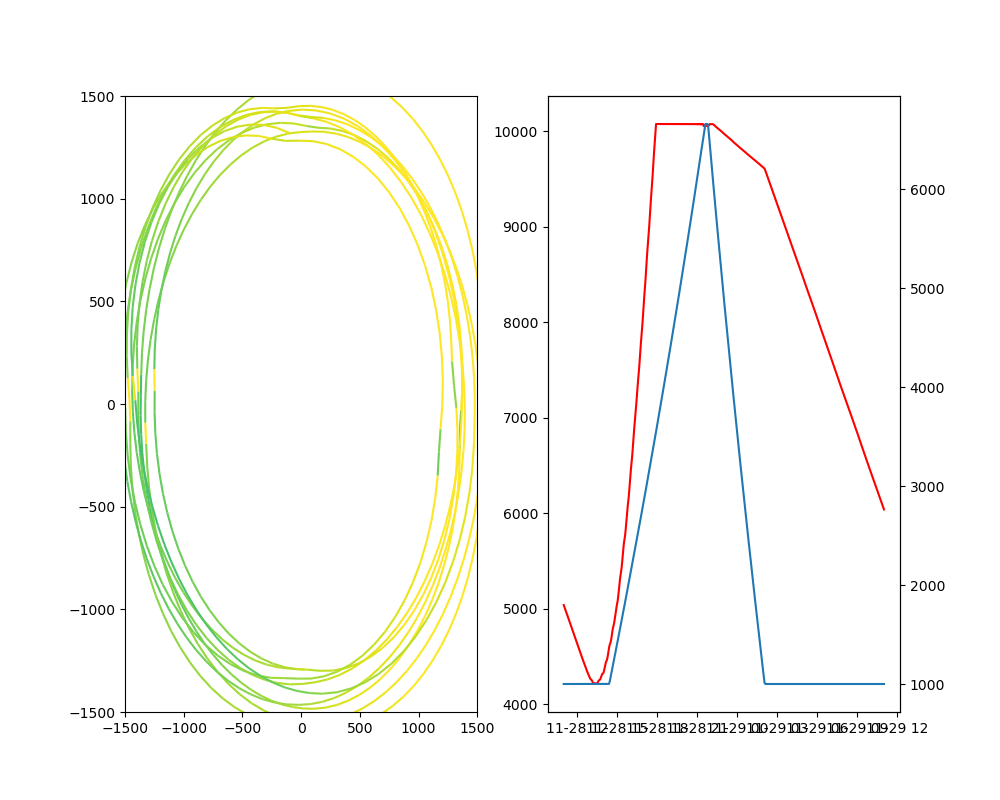

count     8641.000000
mean      7940.917988
std       2009.712278
min       4210.860641
25%       6429.063249
50%       8396.904849
75%       9873.842383
max      10075.000000
dtype: float64

In [13]:
if mode == 'pso':
  bestVec = optimizer.best[0]
  bestFit = optimizer.best[1]
elif mode == 'nm':
  bestVec = optimizer.vertices[-1].vec
  bestFit = optimizer.vertices[-1].fitness

traj, alphas = helper.getTrajBuilder()(bestVec)
flight = Flight(craft, traj, alphas)
stats = judge.flightStats(flight, initial_charge=charge_start_ratio, times=times)


ts = '2020-11-28T12'
te = '2020-11-28T13'
import matplotlib.cm as cm
x = np.array(stats['poses'].x[ts:te])
y = np.array(stats['poses'].y[ts:te])
sola = stats['solar'][ts:te]


from matplotlib.collections import LineCollection
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, 3000)
lc=LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(sola)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
#ax.plot(x, y)
ax[0].set_xlim(-1500, 1500)
ax[0].set_ylim(-1500, 1500)
ax[0].add_collection(lc)

ax[1].plot(stats['battery'], color='red')
ax[1].twinx().plot(stats['poses'].z)

plt.show()

stats['poses'].z.describe()
stats['battery'].describe()

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(stats['battery'] + (craft._mass * 9.8 * (stats['poses'].z - 1000) / 3600))
ax.plot(stats['battery'])

ax.twinx().plot(stats['poses'].z)
bat = stats['battery']
print(bat[bat.index[0]], bat[bat.index[-1]], stats['poses'].z.max() - stats['poses'].z.min())
traj.render()

In [ ]:
# times = pd.date_range(start = '2020-11-28T06', end = '2020-11-29T06', freq='10S', tz='America/Detroit').to_series()

ts = '2020-11-28T16'
te = '2020-11-28T18'
plt.plot(stats['poses'].x[ts:te], stats['poses'].y[ts:te])
#plt.plot(stats['poses'].power)

In [ ]:
print([round(fitness(createVertex(i)), 2) for i in range(10)])
print([round(fitness(v.vec), 2) for v in optimizer.vertices[0:10]])
print(fitness(createVertex(42)))
print(fitness(createVertex(42)))

In [ ]:
if 'thesis.trajectory.SplineyTrajectory' in sys.modules: del sys.modules['thesis.trajectory.SplineyTrajectory']
from thesis.trajectory.SplineyTrajectory import SplineyTrajectory
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
traj = SplineyTrajectory(list(chunks(createVertex(1)[6:], 5)), zSchedule=(1000, 0.1, 0.1, 0.1, 0.1, 0.1), craft=craft, desiredDuration = 24*3600)
traj.render()

In [ ]:
from scipy.optimize import minimize
minimize(lambda vec: -fitness(vec), x0=createVertex(0), method='Nelder-Mead', options={
  'disp': True,
  'adaptive': True
})